In [3]:
import copy
import cv2
import numpy as np

#import pygame
import time

# General Settings
prediction = ''
action = ''
score = 0
img_counter = 500





# parameters
cap_region_x_begin = 0.5  # start point/total width
cap_region_y_end = 0.8  # start point/total width
threshold = 60  # binary threshold
blurValue = 41  # GaussianBlur parameter
bgSubThreshold = 50
learningRate = 0

# variableslt
isBgCaptured = 0  # bool, whether the background captured


def remove_background(frame):
    fgmask = bgModel.apply(frame, learningRate=learningRate)
    kernel = np.ones((3, 3), np.uint8)
    fgmask = cv2.erode(fgmask, kernel, iterations=1)
    res = cv2.bitwise_and(frame, frame, mask=fgmask)
    return res

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [3]:
data_dir = 'Data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((112,112)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(30),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((112,112)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20)

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [5]:
classes = ['Accelerate', 'Left', 'Right', 'Stop']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

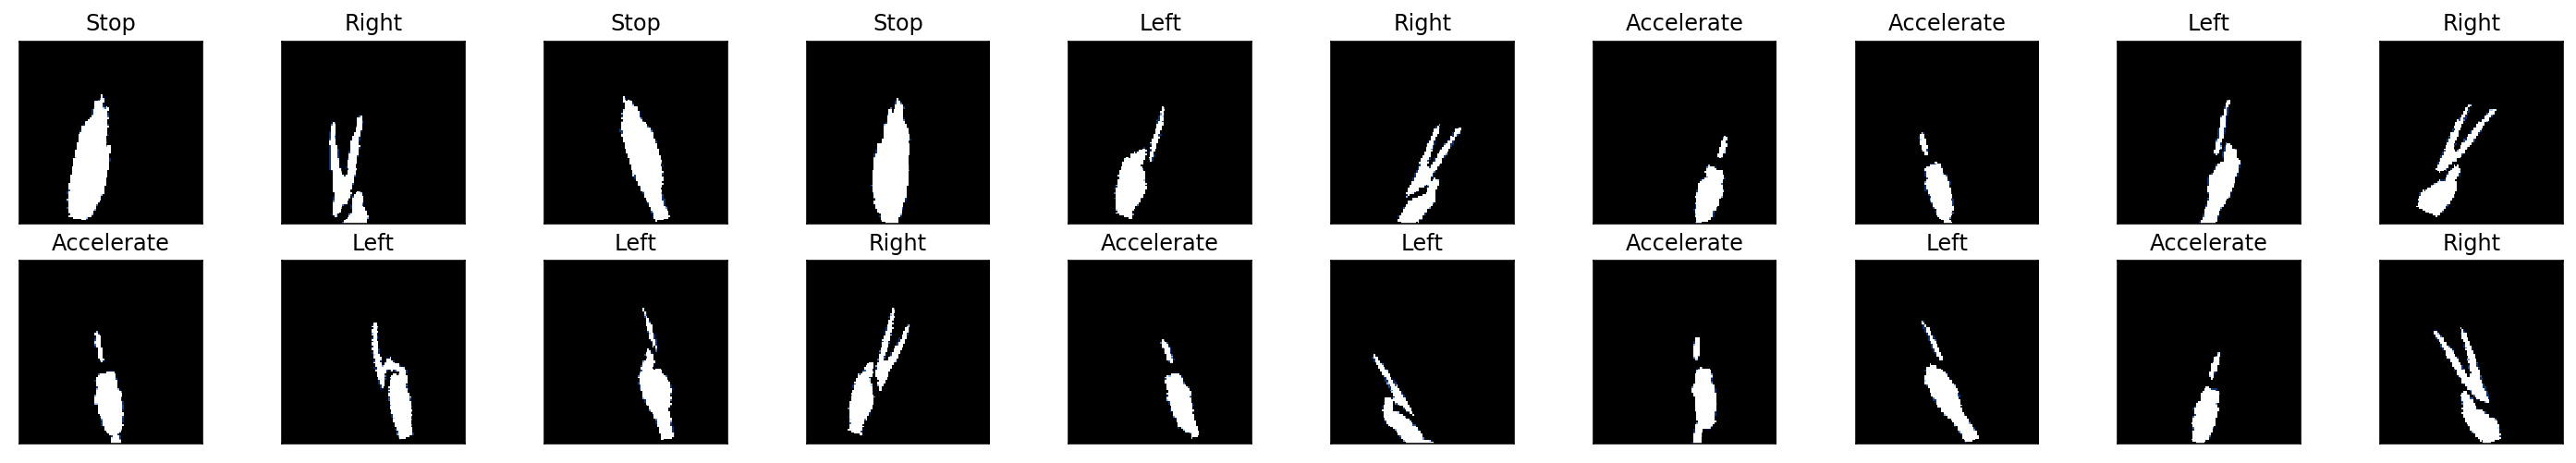

In [6]:
classes = ['Accelerate', 'Left', 'Right', 'Stop']
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [37]:
# Load the pretrained model from pytorch
#frcnn=models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
vgg16=models.vgg16(pretrained=True)
# print out the model structure
#print(frcnn)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [39]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

4


In [40]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [12]:
# number of epochs to train the model
n_epochs = 6

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    # model by default is set to train
    
    valid_loss = 0.0
    
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            
        
        
            if train_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                train_loss/20))
                #torch.save(vgg16.state_dict(), 'model_c1.pt')
                valid_loss_min = train_loss
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.3195497214794158
Validation loss decreased (inf --> 1.319550).  Saving model ...
Epoch 1, Batch 40 loss: 0.9896946609020233
Validation loss decreased (26.390994 --> 0.989695).  Saving model ...
Epoch 2, Batch 20 loss: 0.7477211236953736
Validation loss decreased (19.793893 --> 0.747721).  Saving model ...
Epoch 2, Batch 40 loss: 0.6320833623409271
Validation loss decreased (14.954422 --> 0.632083).  Saving model ...
Epoch 3, Batch 20 loss: 0.5554595947265625
Validation loss decreased (12.641667 --> 0.555460).  Saving model ...
Epoch 3, Batch 40 loss: 0.5134359881281853
Validation loss decreased (11.109192 --> 0.513436).  Saving model ...
Epoch 4, Batch 20 loss: 0.4186145275831222
Validation loss decreased (10.268720 --> 0.418615).  Saving model ...
Epoch 4, Batch 40 loss: 0.4076881885528564
Validation loss decreased (8.372291 --> 0.407688).  Saving model ...
Epoch 5, Batch 20 loss: 0.3702069580554962
Validation loss decreased (8.153764 --> 0.370207).  Saving m

In [13]:
#torch.save(vgg16.state_dict(), 'model_c1.pt')

In [26]:
data.shape

torch.Size([13, 3, 112, 112])

In [13]:
torch.load?

In [52]:
vgg16.load_state_dict(torch.load('model_vgg16_own.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [19]:
#vgg16.load_state_dict(torch.load('model_c1.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


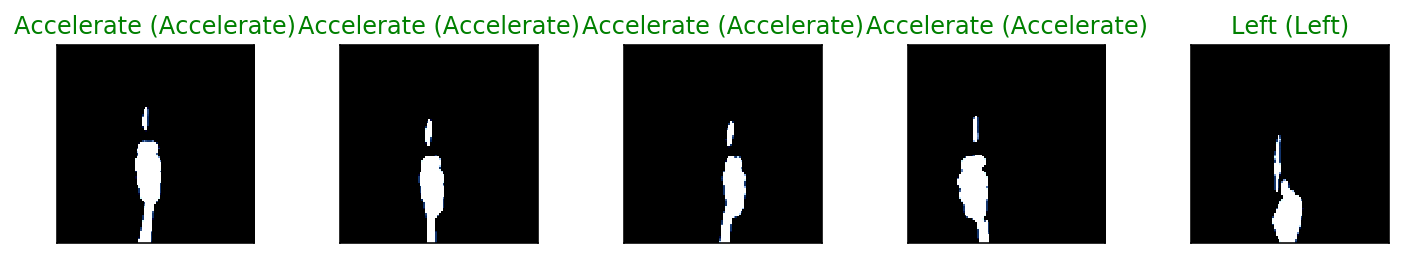

In [53]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].detach().cpu().numpy(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [21]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
## https://stackoverflow.com/questions/14489013/simulate-python-keypresses-for-controlling-a-game
import ctypes
import time

SendInput = ctypes.windll.user32.SendInput

# C struct redefinitions 
PUL = ctypes.POINTER(ctypes.c_ulong)
class KeyBdInput(ctypes.Structure):
    _fields_ = [("wVk", ctypes.c_ushort),
                ("wScan", ctypes.c_ushort),
                ("dwFlags", ctypes.c_ulong),
                ("time", ctypes.c_ulong),
                ("dwExtraInfo", PUL)]

class HardwareInput(ctypes.Structure):
    _fields_ = [("uMsg", ctypes.c_ulong),
                ("wParamL", ctypes.c_short),
                ("wParawwwmH", ctypes.c_ushort)]

class MouseInput(ctypes.Structure):
    _fields_ = [("dx", ctypes.c_long),
                ("dy", ctypes.c_long),
                ("mouseData", ctypes.c_ulong),
                ("dwFlags", ctypes.c_ulong),
                ("time",ctypes.c_ulong),
                ("dwExtraInfo", PUL)]

class Input_I(ctypes.Union):
    _fields_ = [("ki", KeyBdInput),
                 ("mi", MouseInput),
                 ("hi", HardwareInput)]

class Input(ctypes.Structure):
    _fields_ = [("type", ctypes.c_ulong),
                ("ii", Input_I)]

# Actuals Functions

def PressKey(hexKeyCode):
    extra = ctypes.c_ulong(0)
    ii_ = Input_I()
    ii_.ki = KeyBdInput( 0, hexKeyCode, 0x0008, 0, ctypes.pointer(extra) )
    x = Input( ctypes.c_ulong(1), ii_ )
    ctypes.windll.user32.SendInput(1, ctypes.pointer(x), ctypes.sizeof(x))

def ReleaseKey(hexKeyCode):
    extra = ctypes.c_ulong(0)
    ii_ = Input_I()
    ii_.ki = KeyBdInput( 0, hexKeyCode, 0x0008 | 0x0002, 0, ctypes.pointer(extra) )
    x = Input( ctypes.c_ulong(1), ii_ )
    ctypes.windll.user32.SendInput(1, ctypes.pointer(x), ctypes.sizeof(x))

# directx scan codes http://www.gamespp.com/directx/directInputKeyboardScanCodes.html
Accelerate=0x11
Left=0x1E
Right=0x20
Stop=0x1F

def left_key():
    i=0
    while (i<3):
        i=i+1
        PressKey(Accelerate)
        PressKey(Left)
        time.sleep(0.1)
        if i==3:
            ReleaseKey(Accelerate)
            ReleaseKey(Left)
        #time.sleep(0.1)
def right_key():
    i=0
    while (i<3):
        i=i+1
        PressKey(Accelerate)
        PressKey(Right)
        time.sleep(0.1)
        if i==3:
            ReleaseKey(Accelerate)
            ReleaseKey(Right)
        #time.sleep(0.1)
def accelerate_key():
    i=0
    while (i<3):
        i=i+1
        PressKey(Accelerate)
        time.sleep(0.1)
        if i==3:
            ReleaseKey(Accelerate)
        #time.sleep(0.1)
def stop_key():
    i=0
    while (i<3):
        i=i+1
        PressKey(Stop)
        time.sleep(0.1)
        if i==3:
            ReleaseKey(Stop)
        #time.sleep(0.1)

In [17]:
vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [62]:
def get_action(a):
    pos=np.argmax(a[0].detach().cpu().numpy())
    return classes[pos]

def to_tensor(img):
    img=torch.tensor(img,dtype=torch.float)
    img=img.permute(2,0,1)
    img=img/img.max()
    img=img.unsqueeze(axis=0)
    return img

# Camera
camera = cv2.VideoCapture(0)
camera.set(10, 200)
isBgCaptured=0
while camera.isOpened():
    ret, frame = camera.read()
    #frame = cv2.bilateralFilter(frame, 5, 50, 100)  # smoothing filter
    frame = cv2.bilateralFilter(frame, 3, 30, 20)  # smoothing filter
    frame = cv2.flip(frame, 1)  # flip the frame horizontally
    cv2.rectangle(frame, (int(cap_region_x_begin * frame.shape[1]), 0),
                  (frame.shape[1], int(cap_region_y_end * frame.shape[0])), (255, 0, 0), 2)

    cv2.imshow('original', frame)

    # Run once background is captured
    if isBgCaptured == 1:
        img = remove_background(frame)
        img = img[0:int(cap_region_y_end * frame.shape[0]),
              int(cap_region_x_begin * frame.shape[1]):frame.shape[1]]  # clip the ROI
        # cv2.imshow('mask', img)

        # convert the image into binary image
        #-orig-gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #-origblur = cv2.GaussianBlur(gray, (blurValue, blurValue), 0)
        blur = cv2.GaussianBlur(img, (blurValue, blurValue), 0)
        # cv2.imshow('blur', blur)
        ret, thresh = cv2.threshold(blur, threshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        #ret, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Add prediction and action text to thresholded image
        # cv2.putText(thresh, f"Prediction: {prediction} ({score}%)", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))
        # cv2.putText(thresh, f"Action: {action}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))  # Draw the text
        # Draw the text


        thresh = np.stack((thresh,) * 3, axis=-1)
        a=thresh
        thresh = cv2.resize(thresh, (150, 150))
        #thresh = thresh.reshape(1, 224, 224, 3)
        
        img=torch.tensor(thresh,dtype=torch.float)
        img=img.permute(2,0,1)
        img=img.unsqueeze(axis=0)
        #img=img.cuda()
        
        preds=get_action(vgg16(img)) 
        font=cv2.FONT_HERSHEY_SIMPLEX
        a=cv2.putText(a,preds,(100,200),fontFace=font,\
                        color=(0,0,255),fontScale=0.8,lineType=cv2.LINE_AA,thickness=2)
        cv2.imshow('ori', thresh)
        
        k = cv2.waitKey(10)
        if k == 27:
            cv2.destroyAllWindows()
            camera.release()# press ESC to exit all windows at any time
            break
        if preds=='Left':
            left_key()
        if preds=='Right':
            right_key()
        if preds=='Stop':
            stop_key()
        if preds=='Accelerate':
            accelerate_key()
        
                
        
      
        
        


        

    # Keyboard OP
    k = cv2.waitKey(10)
    if k == 27:  # press ESC to exit all windows at any time
        cv2.destroyAllWindows()
        camera.release()
        break
        
    elif k == ord('b'):  # press 'b' to capture the background
        bgModel = cv2.createBackgroundSubtractorMOG2(0, bgSubThreshold)
        #b.set_light(6, on_command)
        time.sleep(2)
        isBgCaptured = 1
        print('Background captured')

    elif k == ord('r'):  # press 'r' to reset the background
        time.sleep(1)
        bgModel = None
        triggerSwitch = False
        isBgCaptured = 0
        print('Reset background')


Background captured


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1529: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::threshold'
